In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import pyproj
import seaborn as sn

In [6]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = '50GB'#str(int(375*ncores/36))+'GB'
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=ncores, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='UCUB0089', # Input your project ID here
    walltime='1:20:00', # Amount of wall time
    interface='ib0', # Interface to use
)
cluster.scale(ncores)
client = Client(cluster)

/glade/work/yifanc/anaconda3/envs/py3/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41696 instead
  http_address["port"], self.http_server.port


In [7]:
cluster

In [8]:
client

Client Scheduler: tcp://10.12.206.54:45516 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yifanc/proxy/41696/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## useful functions

In [9]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord]))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord]))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
    #OUTPUT as DataArray
    da_map = xr.DataArray(array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

In [10]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')


In [26]:
# csvfile='/glade/campaign/asp/djk2120/PPEn11/csvs/SP_ensemble.csv'
csvfile='ppe/SP_ensemble.csv'
df_sp_ensemble = pd.read_csv(csvfile,index_col=[0])

In [12]:
#histdir='/glade/scratch/djk2120/PPEn08/CTL2010/hist/'
histdir='/glade/campaign/asp/djk2120/PPEn11/CTL2010SP/hist/'
tape='h0'
members=[]
files=[]
for member in df_sp_ensemble.index.values:#np.arange(400):
    # member='OAAT'+str(i).zfill(4)
    file=glob.glob(histdir+'*'+member+'*'+tape+'*.nc')
    if len(file)>0:
        members.append(member)
        files.append(file[0])

# work with 1 file

In [13]:
ds = xr.open_dataset(files[0])
ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug

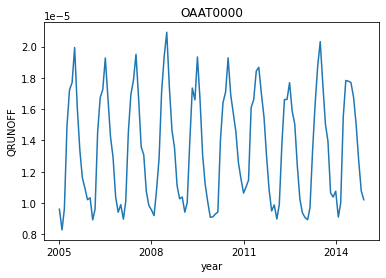

In [14]:
## make a global timeseries
la_file = '/glade/u/home/yifanc/PPE/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2
qrunoff = ds.QRUNOFF.mean(dim='gridcell')
qrunoff.plot()
plt.xlabel('year')
plt.title(members[0]);

In [15]:
# transfer the sparse grid to geopandas file
df_sparse_grid = pd.DataFrame(np.transpose([ds.gridcell,ds.grid1d_lat,ds.grid1d_lon]),columns=['grid_id','grid_lat','grid_lon'])
grid_need_adjust_lon = df_sparse_grid[df_sparse_grid['grid_lon']>180].index.values
df_sparse_grid.loc[grid_need_adjust_lon,'grid_lon'] -= 360

In [16]:
gdf_sparse_grid = gpd.GeoDataFrame(df_sparse_grid, geometry= gpd.points_from_xy(df_sparse_grid.grid_lon, df_sparse_grid.grid_lat))

In [17]:
shp_domain = gpd.read_file('/glade/work/yifanc/NNA/domain/shapefile/NNAStudyDomain/NNAstudydomain.shp')

In [18]:
# find the ID of gridcells within the study domain
grid_within_domain = []
for grid in df_sparse_grid.index.values:
    if df_sparse_grid['geometry'].loc[grid].within(shp_domain.geometry[0]):
        grid_within_domain.append(grid)
print(grid_within_domain)

[306, 316, 329, 330, 342, 353, 354]


In [19]:
gdf_sparse_grid = gdf_sparse_grid.set_crs(epsg=4326)

# Work with multiple ensemble members

In [20]:
# defining a preprocessing function
#   this way I only take GPP and TWS
#   otherwise you'll read in ~500 data_vars (for h0)
data_vars=['QRUNOFF','H2OSNO','QFLX_EVAP_TOT','RAIN','SNOW']
def preprocess(ds):
    return ds[data_vars]

In [25]:
xr.open_dataset(files[0])

<xarray.Dataset>
Dimensions:                            (cft: 2, column: 2599, gridcell: 400, hist_interval: 2, landunit: 1148, lat: 96, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lon: 144, ltype: 9, nvegwcs: 4, pft: 4387, time: 120)
Coordinates:
  * levgrnd                            (levgrnd) float32 0.01 0.04 ... 41.998436
  * levsoi                             (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                             (levlak) float32 0.05 0.6 ... 44.775
  * levdcmp                            (levdcmp) float32 1.0
  * time                               (time) object 2005-02-01 00:00:00 ... ...
  * lon                                (lon) float32 0.0 2.5 5.0 ... 355.0 357.5
  * lat                                (lat) float32 -90.0 -88.10526 ... 90.0
Dimensions without coordinates: cft, column, gridcell, hist_interval, landunit, ltype, nvegwcs, pft
Data variables:
    mcdate                             (time) int32 ...
    mcsec                              (time) int32 ...
    mdcur                              (time) int32 ...
    mscur                              (time) int32 ...
    nstep                              (time) int32 ...
    time_bounds                        (time, hist_interval) object ...
    date_written                       (time) |S16 ...
    time_written                       (time) |S16 ...
    area                               (lat, lon) float32 ...
    landfrac                           (lat, lon) float32 ...
    landmask                           (lat, lon) float64 ...
    pftmask                            (lat, lon) float64 ...
    nbedrock                           (lat, lon) float64 ...
    grid1d_lon                         (gridcell) float64 ...
    grid1d_lat                         (gridcell) float64 ...
    grid1d_ixy                         (gridcell) float64 ...
    grid1d_jxy                         (gridcell) float64 ...
    land1d_lon                         (landunit) float64 ...
    land1d_lat                         (landunit) float64 ...
    land1d_ixy                         (landunit) float64 ...
    land1d_jxy                         (landunit) float64 ...
    land1d_gi                          (landunit) float64 ...
    land1d_wtgcell                     (landunit) float64 ...
    land1d_ityplunit                   (landunit) float64 ...
    land1d_active                      (landunit) float64 ...
    cols1d_lon                         (column) float64 ...
    cols1d_lat                         (column) float64 ...
    cols1d_ixy                         (column) float64 ...
    cols1d_jxy                         (column) float64 ...
    cols1d_gi                          (column) float64 ...
    cols1d_li                          (column) float64 ...
    cols1d_wtgcell                     (column) float64 ...
    cols1d_wtlunit                     (column) float64 ...
    cols1d_itype_col                   (column) float64 ...
    cols1d_itype_lunit                 (column) float64 ...
    cols1d_active                      (column) float64 ...
    pfts1d_lon                         (pft) float64 ...
    pfts1d_lat                         (pft) float64 ...
    pfts1d_ixy                         (pft) float64 ...
    pfts1d_jxy                         (pft) float64 ...
    pfts1d_gi                          (pft) float64 ...
    pfts1d_li                          (pft) float64 ...
    pfts1d_ci                          (pft) float64 ...
    pfts1d_wtgcell                     (pft) float64 ...
    pfts1d_wtlunit                     (pft) float64 ...
    pfts1d_wtcol                       (pft) float64 ...
    pfts1d_itype_veg                   (pft) float64 ...
    pfts1d_itype_col                   (pft) float64 ...
    pfts1d_itype_lunit                 (pft) float64 ...
    pfts1d_active                      (pft) float64 ...
    ATM_TOPO                           (time, gridcell) float32 ...
    BCDEP                              (time, gridc

In [ ]:
%%time
ds_ens=xr.open_mfdataset(files,
                     combine='nested',
                     concat_dim='ens',
                     parallel=True,
                     preprocess=preprocess)
ds_ens['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug

In [ ]:
#append some useful information about the parameters
csvfile='ppe/SP_ensemble.csv'
keys=pd.read_csv(csvfile,header=None)
params=[]
minmax=[]
for member in members:
    ix = member==keys[0]
    params.append(keys[1][ix].values[0])
    minmax.append(keys[2][ix].values[0])
ds_ens['param']  = xr.DataArray(params,dims='ens')
ds_ens['minmax'] = xr.DataArray(minmax,dims='ens')

In [26]:
param_df = pd.read_csv('ppe/params.csv')

In [27]:
param_list = ds_ens.param.values

In [140]:
# param_df['CLM5 Default Value(s)']

In [28]:
min_list = np.array([])
max_list = np.array([])
default_list = np.array([])
correspond_param_list = np.array([])
correspond_param_id_list = np.array([])

for i,param in enumerate(param_list):
    param_sel = param_df[param_df['name']==param]
    if len(param_sel) == 1:
        min_list = np.concatenate([min_list, param_sel['min'].values])
        max_list = np.concatenate([max_list, param_sel['max'].values])
        default_list = np.concatenate([default_list, param_sel['CLM5 Default Value(s)'].values])
        correspond_param_list = np.concatenate([correspond_param_list,[param]])
        correspond_param_id_list = np.concatenate([correspond_param_id_list,[i]])
    else:
        print(i,param)
correspond_param_id_list = correspond_param_id_list.astype(np.int32)

0 default
361 KCN
362 KCN
363 LF
364 LF
365 FR
366 FR
367 Q10
368 Q10
369 CWD
370 CWD


In [43]:
ds_ens_w_domain = ds_ens.sel(gridcell=grid_within_domain)
ds_ens_w_domain.load()

<xarray.Dataset>
Dimensions:        (ens: 371, gridcell: 7, time: 120)
Coordinates:
  * time           (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    QRUNOFF        (ens, time, gridcell) float32 6.4112144e-12 ... 0.0
    H2OSNO         (ens, time, gridcell) float32 41.37546 127.61966 ... 9.40426
    QFLX_EVAP_TOT  (ens, time, gridcell) float32 1.0974841e-07 ... -4.3170294...
    RAIN           (ens, time, gridcell) float32 0.0 0.0 ... 0.0 0.0
    SNOW           (ens, time, gridcell) float32 1.1068893e-05 ... 0.0
    param          (ens) <U32 'default' 'taulnir' 'taulnir' ... 'CWD' 'CWD'
    minmax         (ens) <U7 'default' 'min' 'max' 'min' ... 'max' 'min' 'max'
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 04/26/21 15:05:00
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    username:                                  djk2120
    version:                                   branch_tags/PPE.n08_ctsm5.1.de...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   PPEn08_CTL2010_PROD_001
    Surface_dataset:                           surfdata_1.9x2.5_hist_16pfts_I...
    Initial_conditions_dataset:                CTL2010_OAAT0000_postSASUresta...
    PFT_physiological_constants_dataset:       OAAT0000.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:                             3
    ctype_landice_multiple_elevation_classes:  4*100+m, m=1,glcnec
    ctype_deep_lake:                           5
    ctype_wetland:                             6
    ctype_urban_roof:                          71
    ctype_urban_sunwall:                       72
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn08_CTL2010_PROD_001.clm2...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [44]:
ds_ens_mean = ds_ens.mean(dim='time')
ds_ens_mean.load()

<xarray.Dataset>
Dimensions:        (ens: 371, gridcell: 400)
Dimensions without coordinates: ens, gridcell
Data variables:
    QRUNOFF        (ens, gridcell) float32 1.328311e-05 ... 1.178797e-05
    H2OSNO         (ens, gridcell) float32 2.6097128 25.70823 ... 230.82367
    QFLX_EVAP_TOT  (ens, gridcell) float32 1.3724124e-05 ... 2.7781658e-07
    RAIN           (ens, gridcell) float32 2.5161531e-05 ... 2.0248322e-06
    SNOW           (ens, gridcell) float32 1.8428661e-06 ... 1.0272275e-05

In [45]:
grid_within_domain

[306, 316, 329, 330, 342, 353, 354]

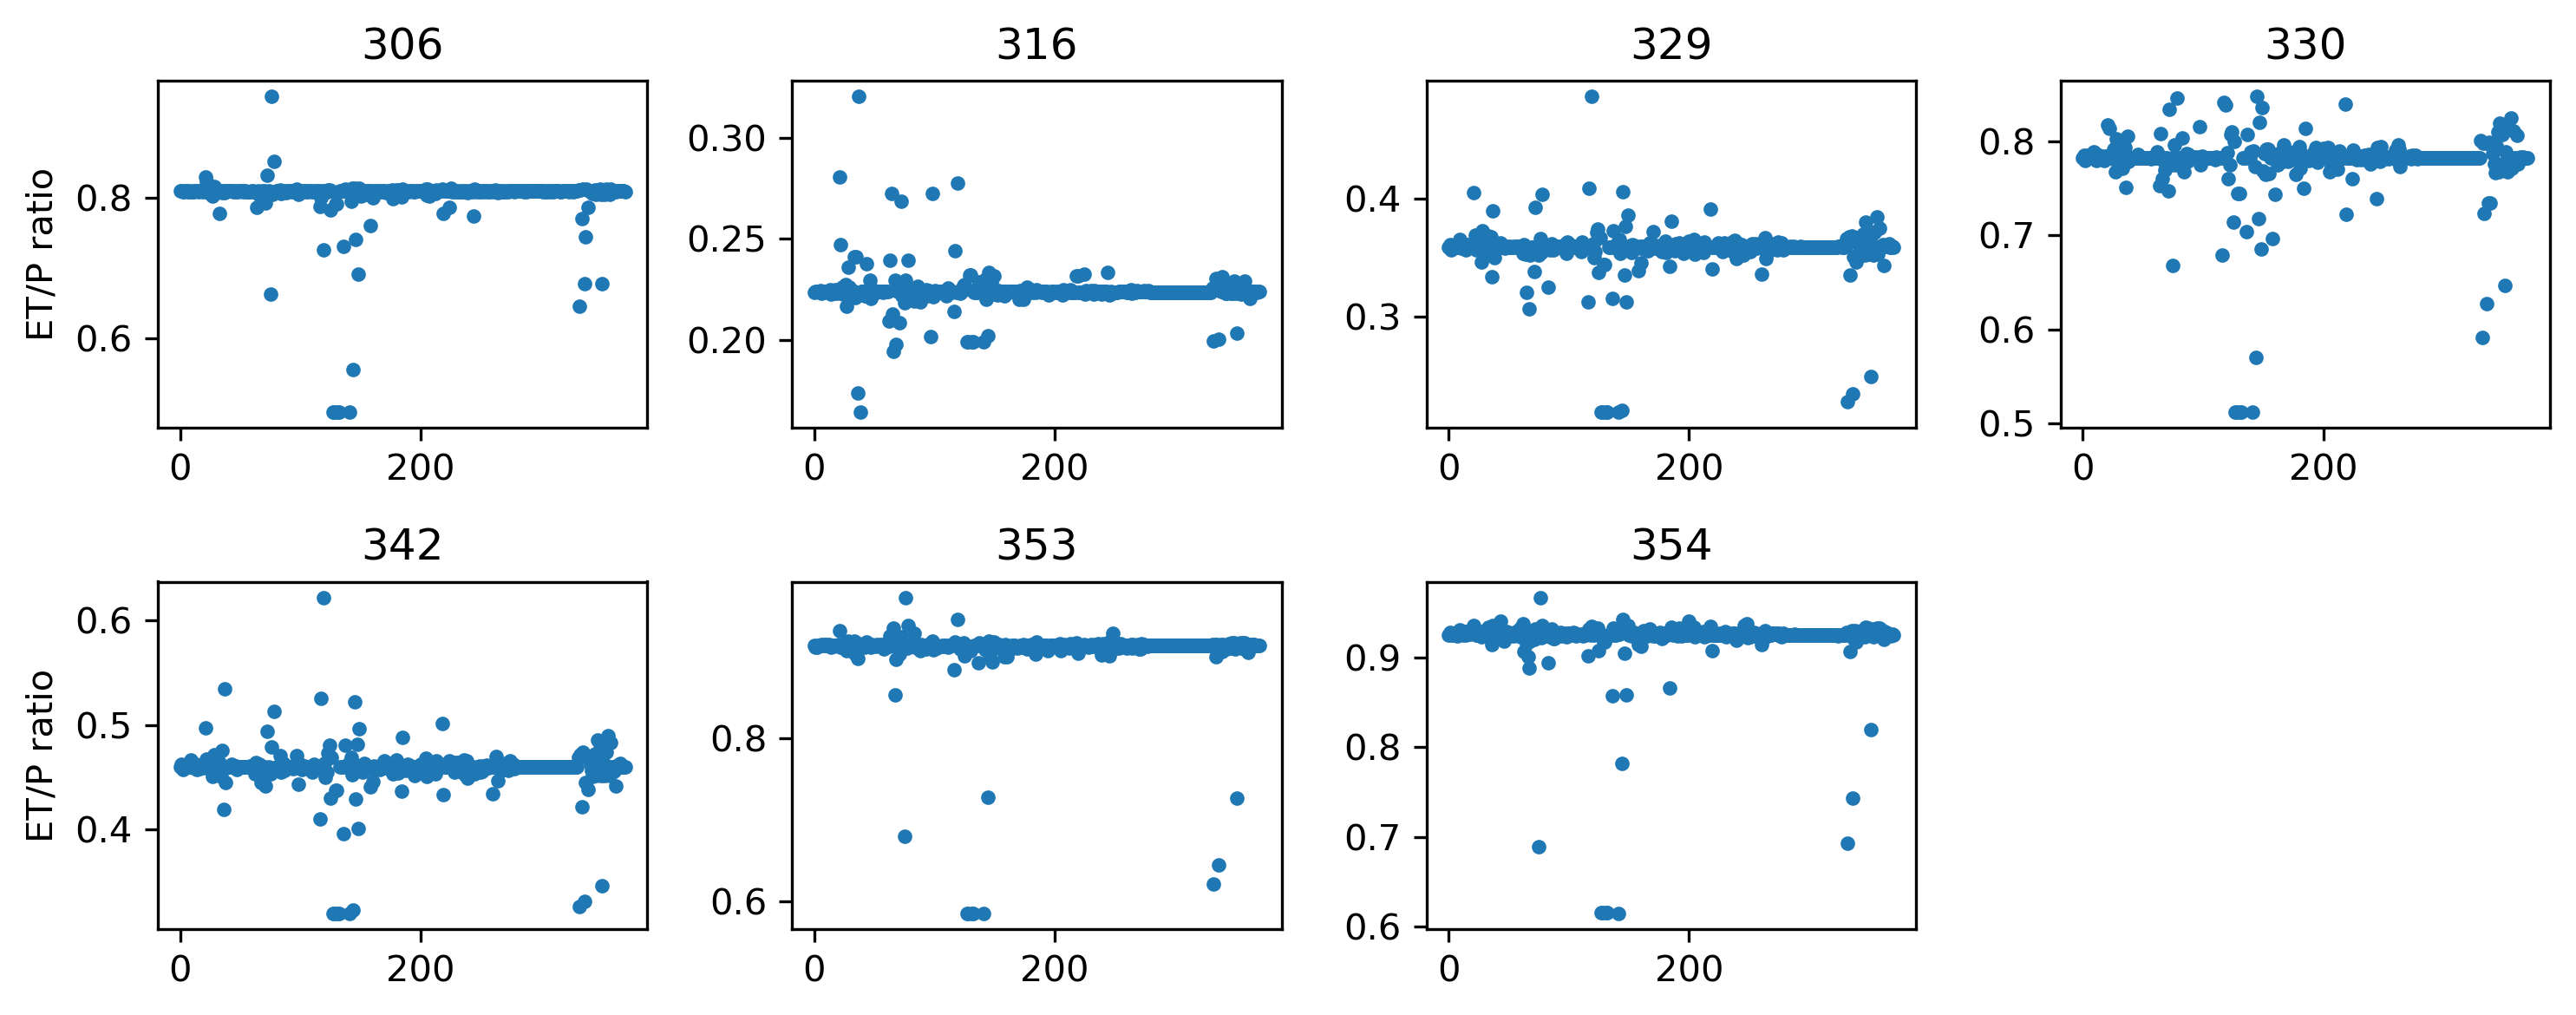

In [46]:
plt.figure(figsize=[10,4],dpi=100)
for i_grid,grid in enumerate(grid_within_domain):
    plt.subplot(2,4,i_grid+1)
    tot_precip = ds_ens_mean.RAIN.sel(gridcell=grid) + ds_ens_mean.SNOW.sel(gridcell=grid)
    tot_evp = ds_ens_mean.QFLX_EVAP_TOT.sel(gridcell=grid)
    tot_runoff = ds_ens_mean.QRUNOFF.sel(gridcell=grid)
    plt.plot(tot_evp/tot_precip, '.')
    plt.title(grid)
    if i_grid % 4 == 0:
        plt.ylabel('ET/P ratio')
plt.tight_layout()

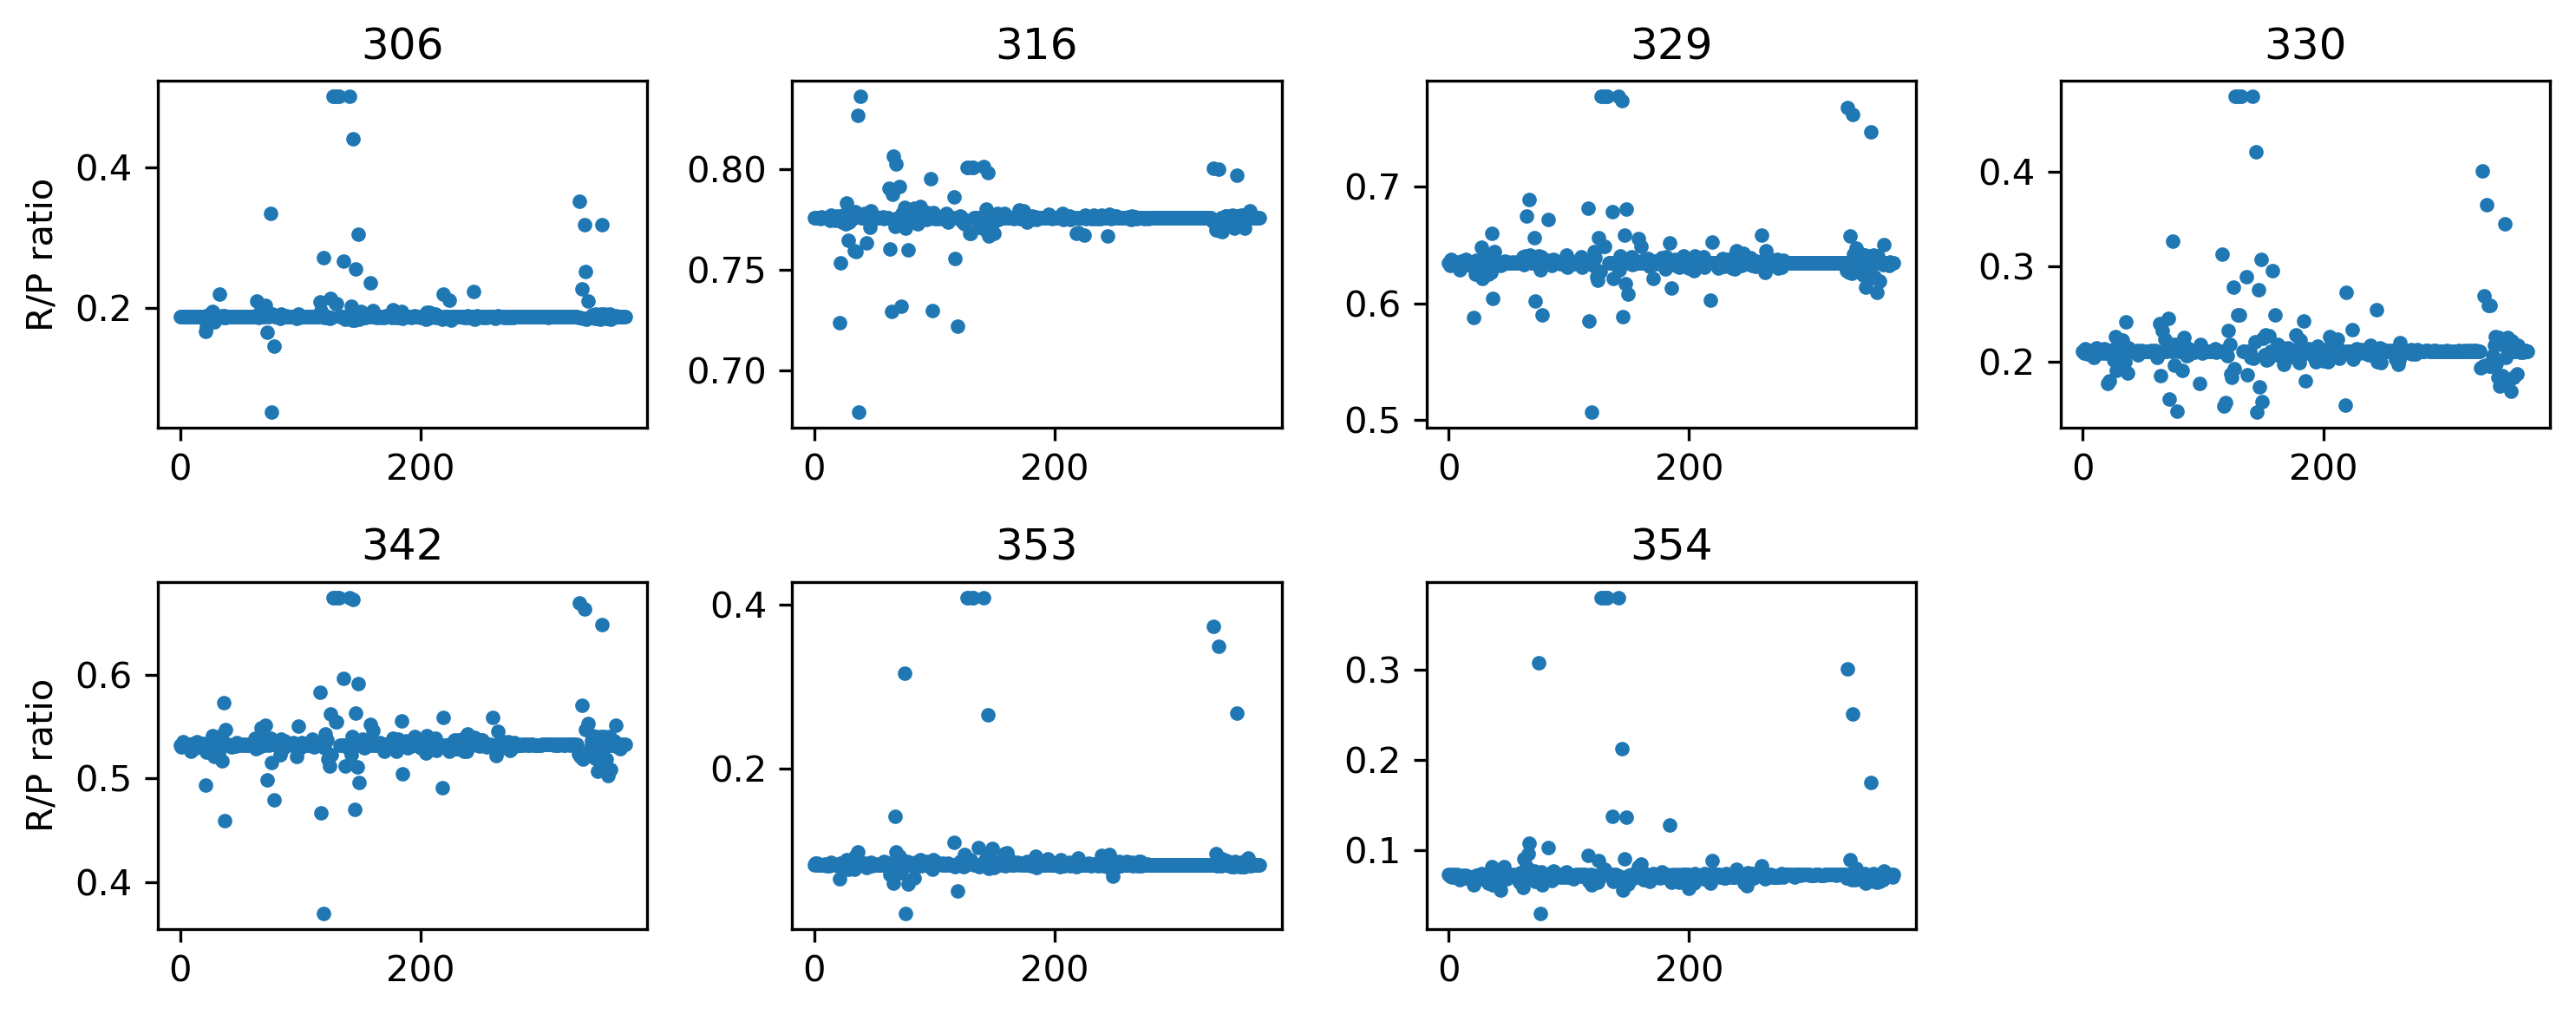

In [47]:
plt.figure(figsize=[10,4],dpi=100)
for i_grid,grid in enumerate(grid_within_domain):
    plt.subplot(2,4,i_grid+1)
    tot_precip = ds_ens_mean.RAIN.sel(gridcell=grid) + ds_ens_mean.SNOW.sel(gridcell=grid)
    tot_evp = ds_ens_mean.QFLX_EVAP_TOT.sel(gridcell=grid)
    tot_runoff = ds_ens_mean.QRUNOFF.sel(gridcell=grid)
    plt.plot(tot_runoff/tot_precip, '.')
    plt.title(grid)
    if i_grid % 4 == 0:
        plt.ylabel('R/P ratio')
plt.tight_layout()

Text(0, 0.5, 'ET/P ratio')

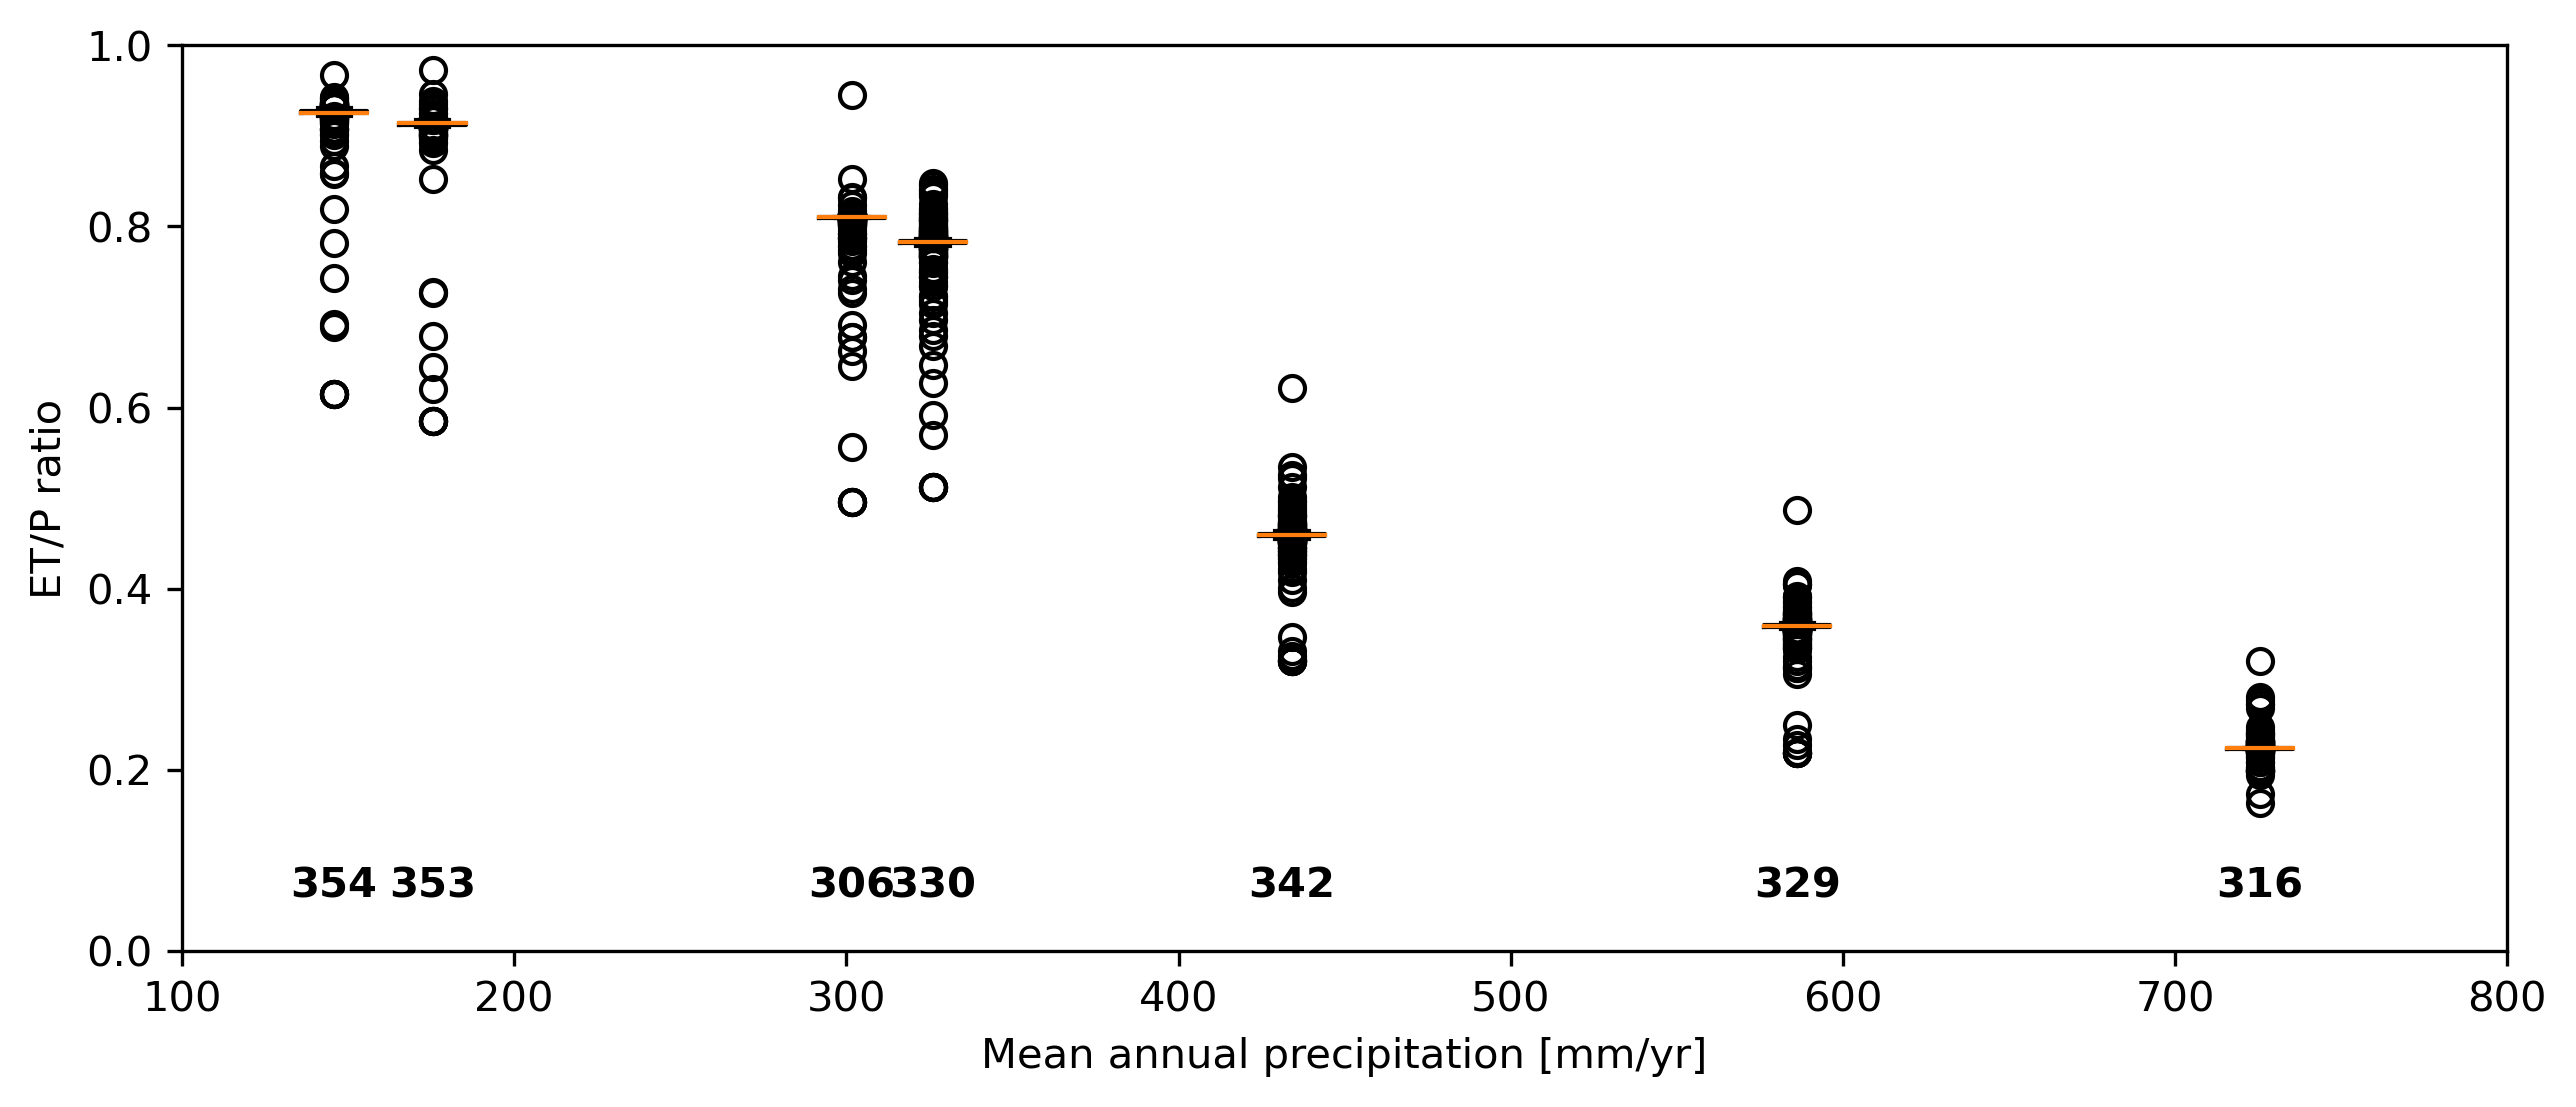

In [30]:
plt.figure(figsize=[10,4],dpi=100)
for i_grid,grid in enumerate(grid_within_domain):
    tot_precip = ds_ens_mean.RAIN.sel(gridcell=grid) + ds_ens_mean.SNOW.sel(gridcell=grid)
    tot_evp = ds_ens_mean.QFLX_EVAP_TOT.sel(gridcell=grid)
    ep_ratio = tot_evp/tot_precip
    precip_annual = tot_precip[0]*86400*365
    plt.boxplot(ep_ratio.values,positions=[precip_annual], widths=20)
    plt.text(precip_annual,0.05, "%s"%(grid),ha='center',va='bottom',weight='bold')

plt.xticks(np.arange(100,901,100),np.arange(100,901,100))
plt.xlabel('Mean annual precipitation [mm/yr]')
plt.xlim([100,800])
plt.ylim(0,1)
plt.ylabel('ET/P ratio')

Text(0, 0.5, 'R/P ratio')

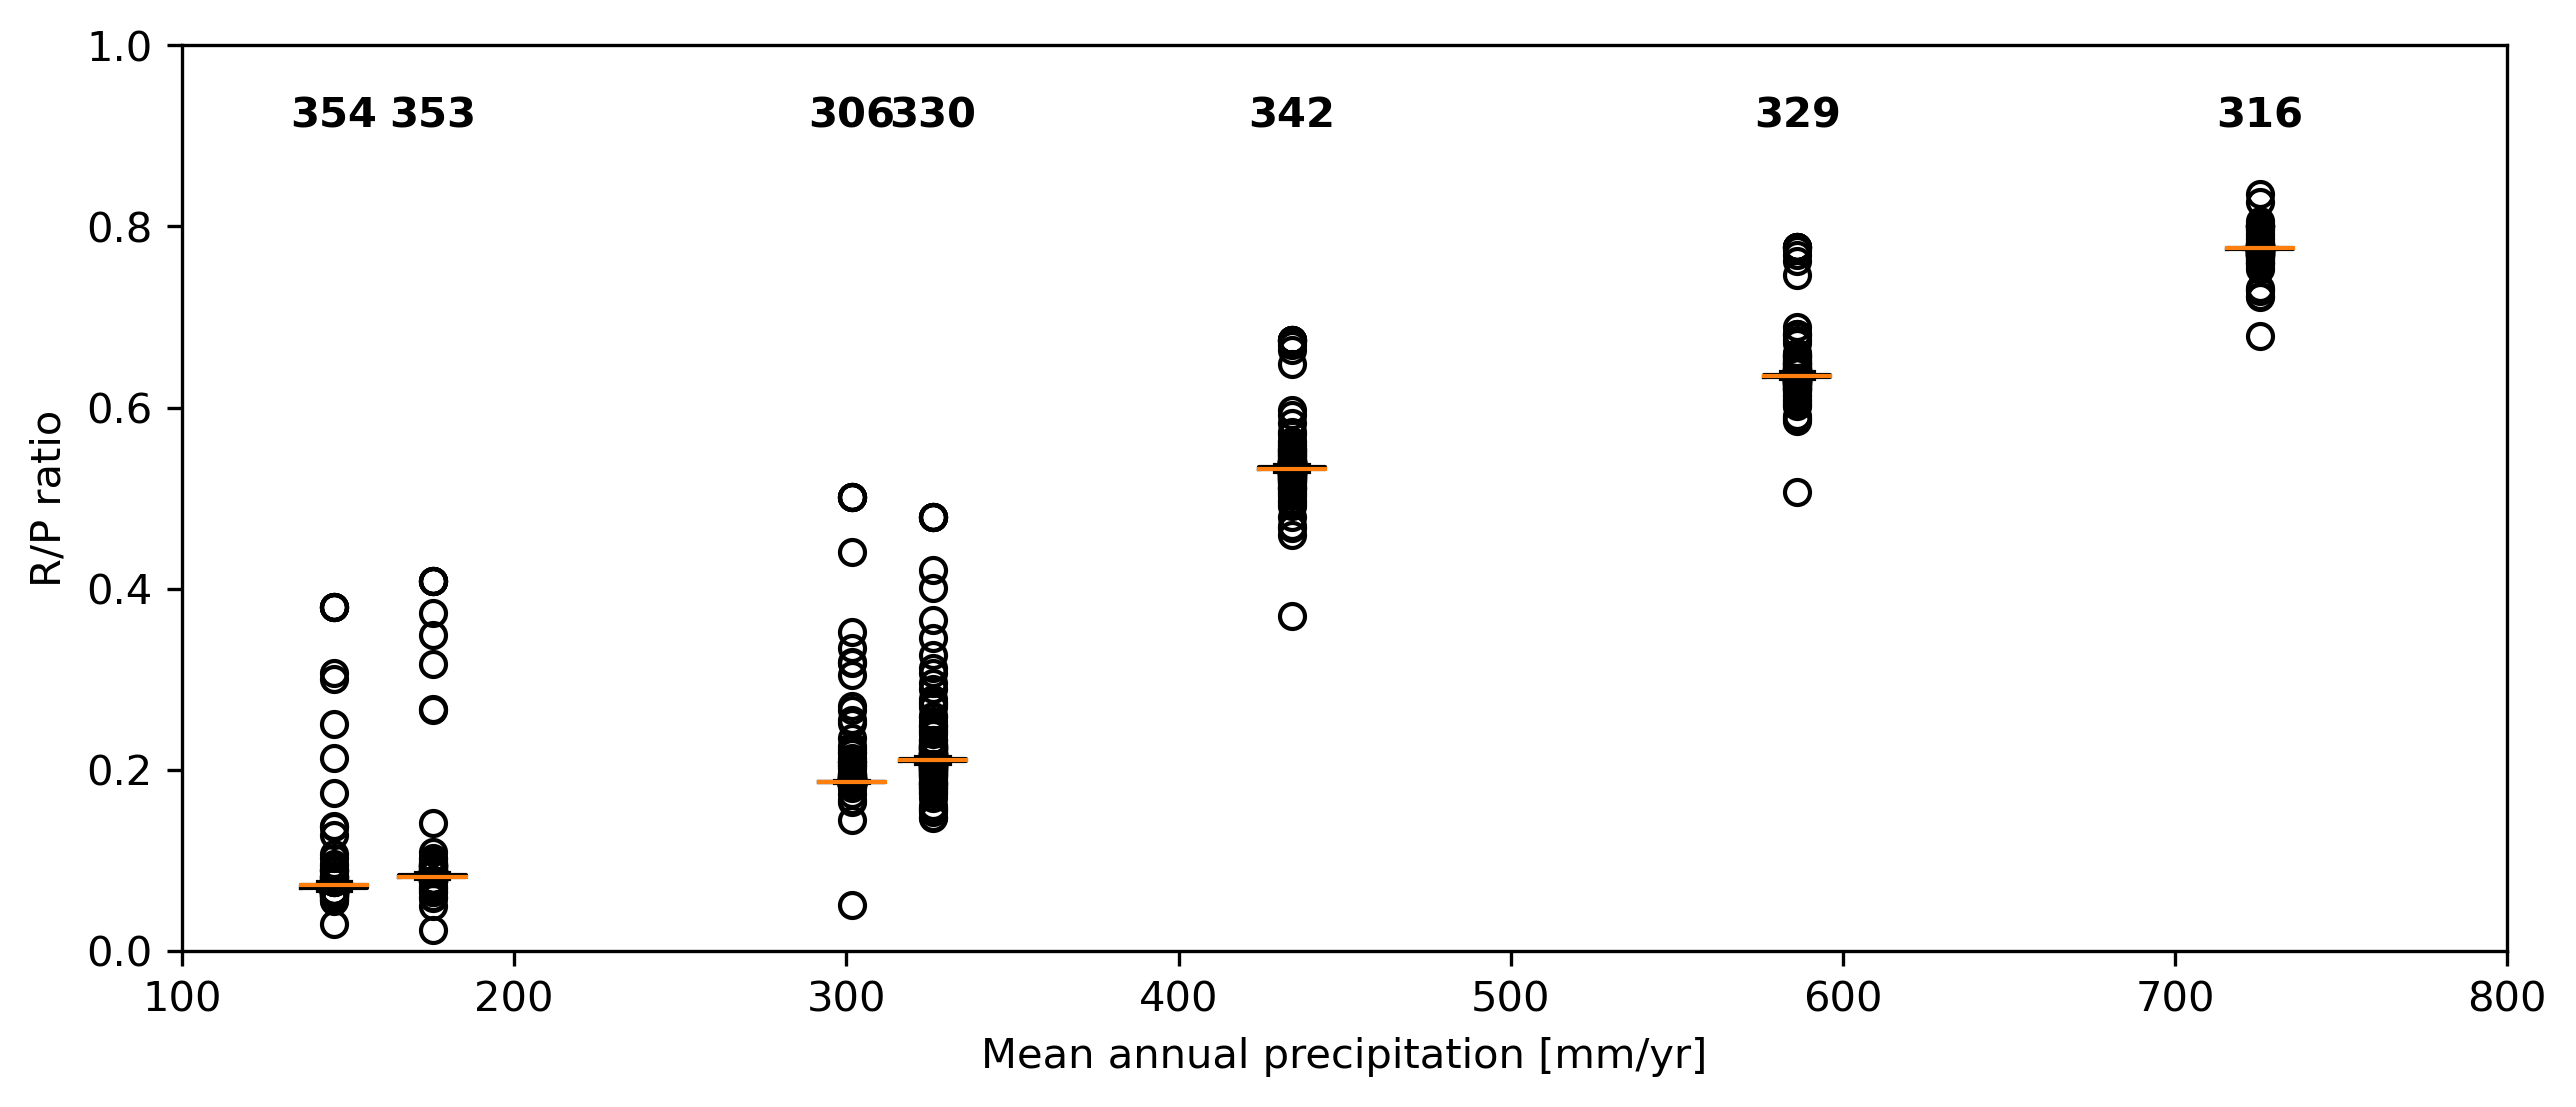

In [110]:
plt.figure(figsize=[10,4],dpi=100)
for i_grid,grid in enumerate(grid_within_domain):
    tot_precip = ds_ens_mean.RAIN.sel(gridcell=grid) + ds_ens_mean.SNOW.sel(gridcell=grid)
    tot_runoff = ds_ens_mean.QRUNOFF.sel(gridcell=grid)
    ep_ratio = tot_runoff/tot_precip
    precip_annual = tot_precip[0]*86400*365
    plt.boxplot(ep_ratio.values,positions=[precip_annual], widths=20)
    plt.text(precip_annual,0.9, "%s"%(grid),ha='center',va='bottom',weight='bold')

plt.xticks(np.arange(100,901,100),np.arange(100,901,100))
plt.xlabel('Mean annual precipitation [mm/yr]')
plt.xlim([100,800])
plt.ylim(0,1)
plt.ylabel('R/P ratio')

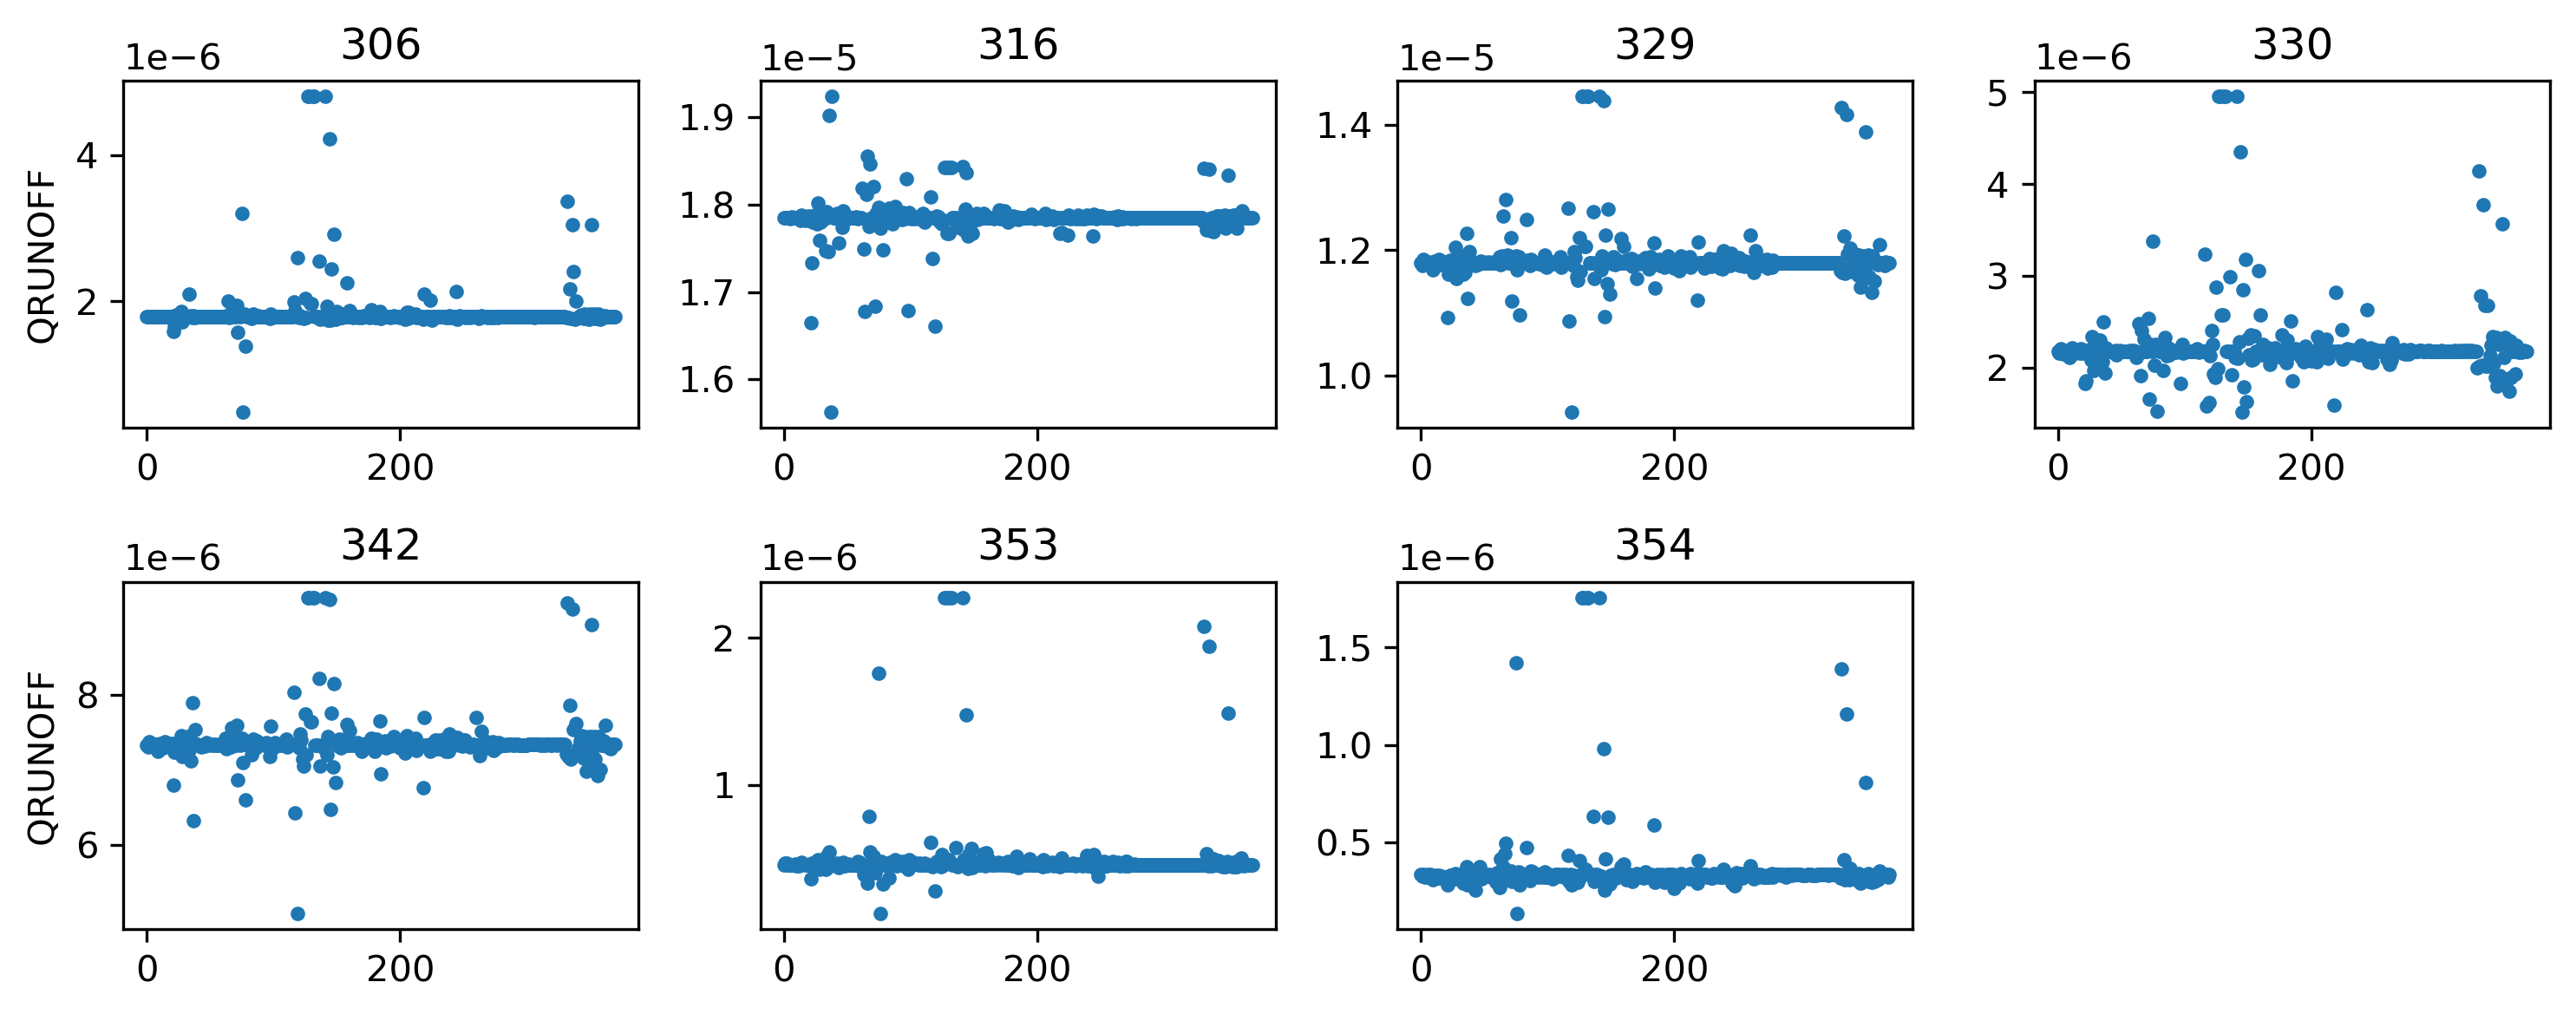

In [31]:
plt.figure(figsize=[10,4],dpi=100)
for i_grid,grid in enumerate(grid_within_domain):
    plt.subplot(2,4,i_grid+1)
    tot_runoff = ds_ens_mean.QRUNOFF.sel(gridcell=grid)
    plt.plot(tot_runoff, '.')
    plt.title(grid)
    if i_grid % 4 == 0:
        plt.ylabel('QRUNOFF')
plt.tight_layout()

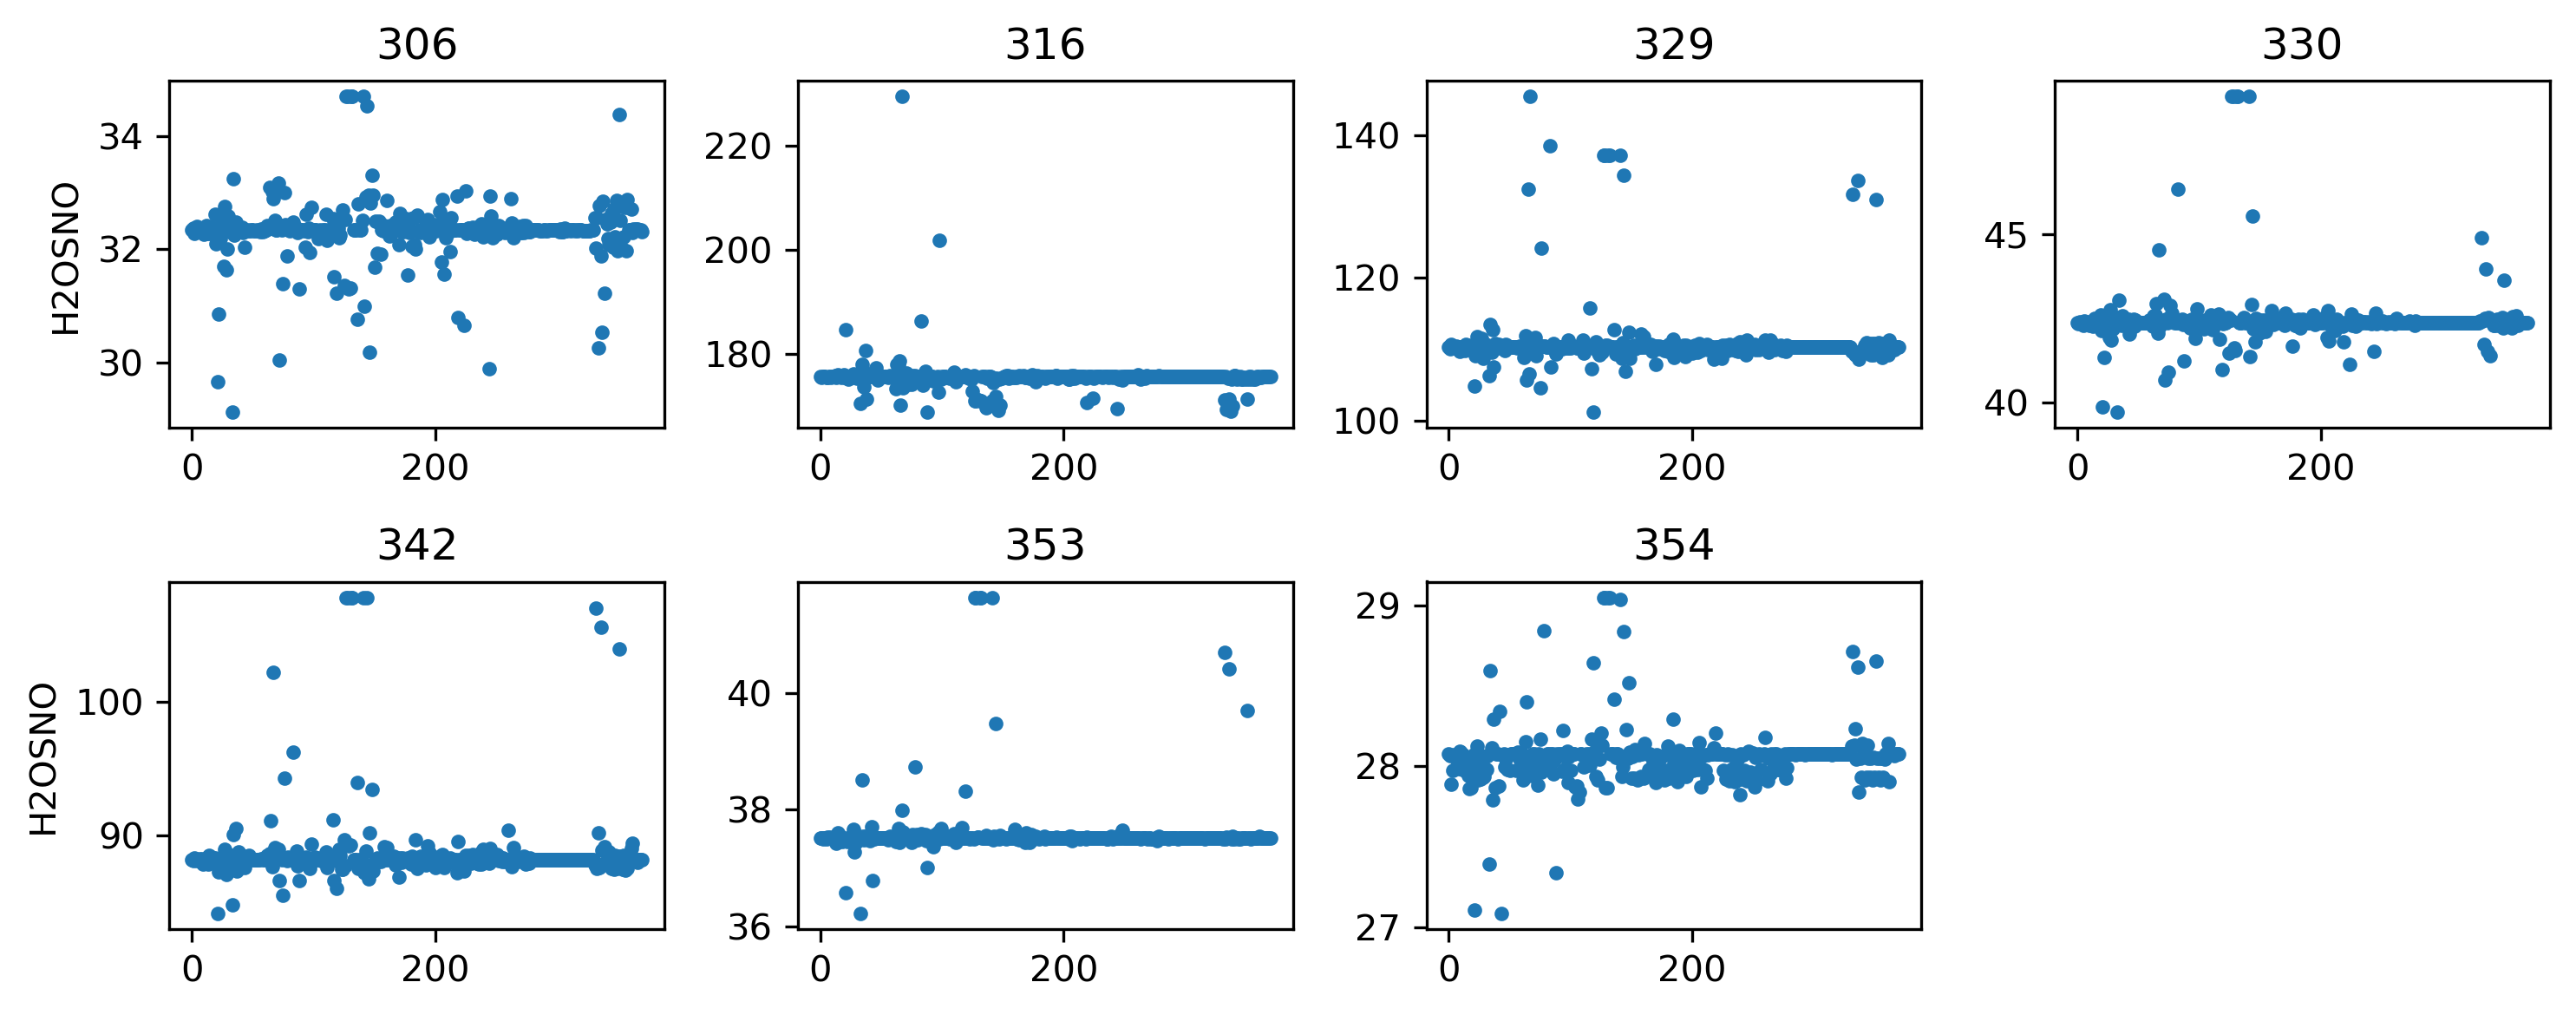

In [32]:
plt.figure(figsize=[10,4],dpi=100)
for i_grid,grid in enumerate(grid_within_domain):
    plt.subplot(2,4,i_grid+1)
    tot_runoff = ds_ens_mean.H2OSNO.sel(gridcell=grid)
    plt.plot(tot_runoff, '.')
    plt.title(grid)
    if i_grid % 4 == 0:
        plt.ylabel('H2OSNO')
plt.tight_layout()

In [31]:
hydro_mean_seasonality = ds_ens.sel(gridcell=grid_within_domain).groupby('time.month').mean(dim='time')
hydro_mean_seasonality.load()

<xarray.Dataset>
Dimensions:        (ens: 371, gridcell: 7, month: 12)
Coordinates:
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: ens, gridcell
Data variables:
    QRUNOFF        (month, ens, gridcell) float32 8.869416e-12 ... 4.159751e-11
    H2OSNO         (month, ens, gridcell) float32 60.54597 ... 39.892372
    QFLX_EVAP_TOT  (month, ens, gridcell) float32 -2.7905185e-07 ... -2.93013...
    RAIN           (month, ens, gridcell) float32 7.45756e-09 ... 0.0
    SNOW           (month, ens, gridcell) float32 7.79051e-06 ... 4.272213e-06

done with grid 306
done with grid 316
done with grid 329
done with grid 330
done with grid 342
done with grid 353
done with grid 354


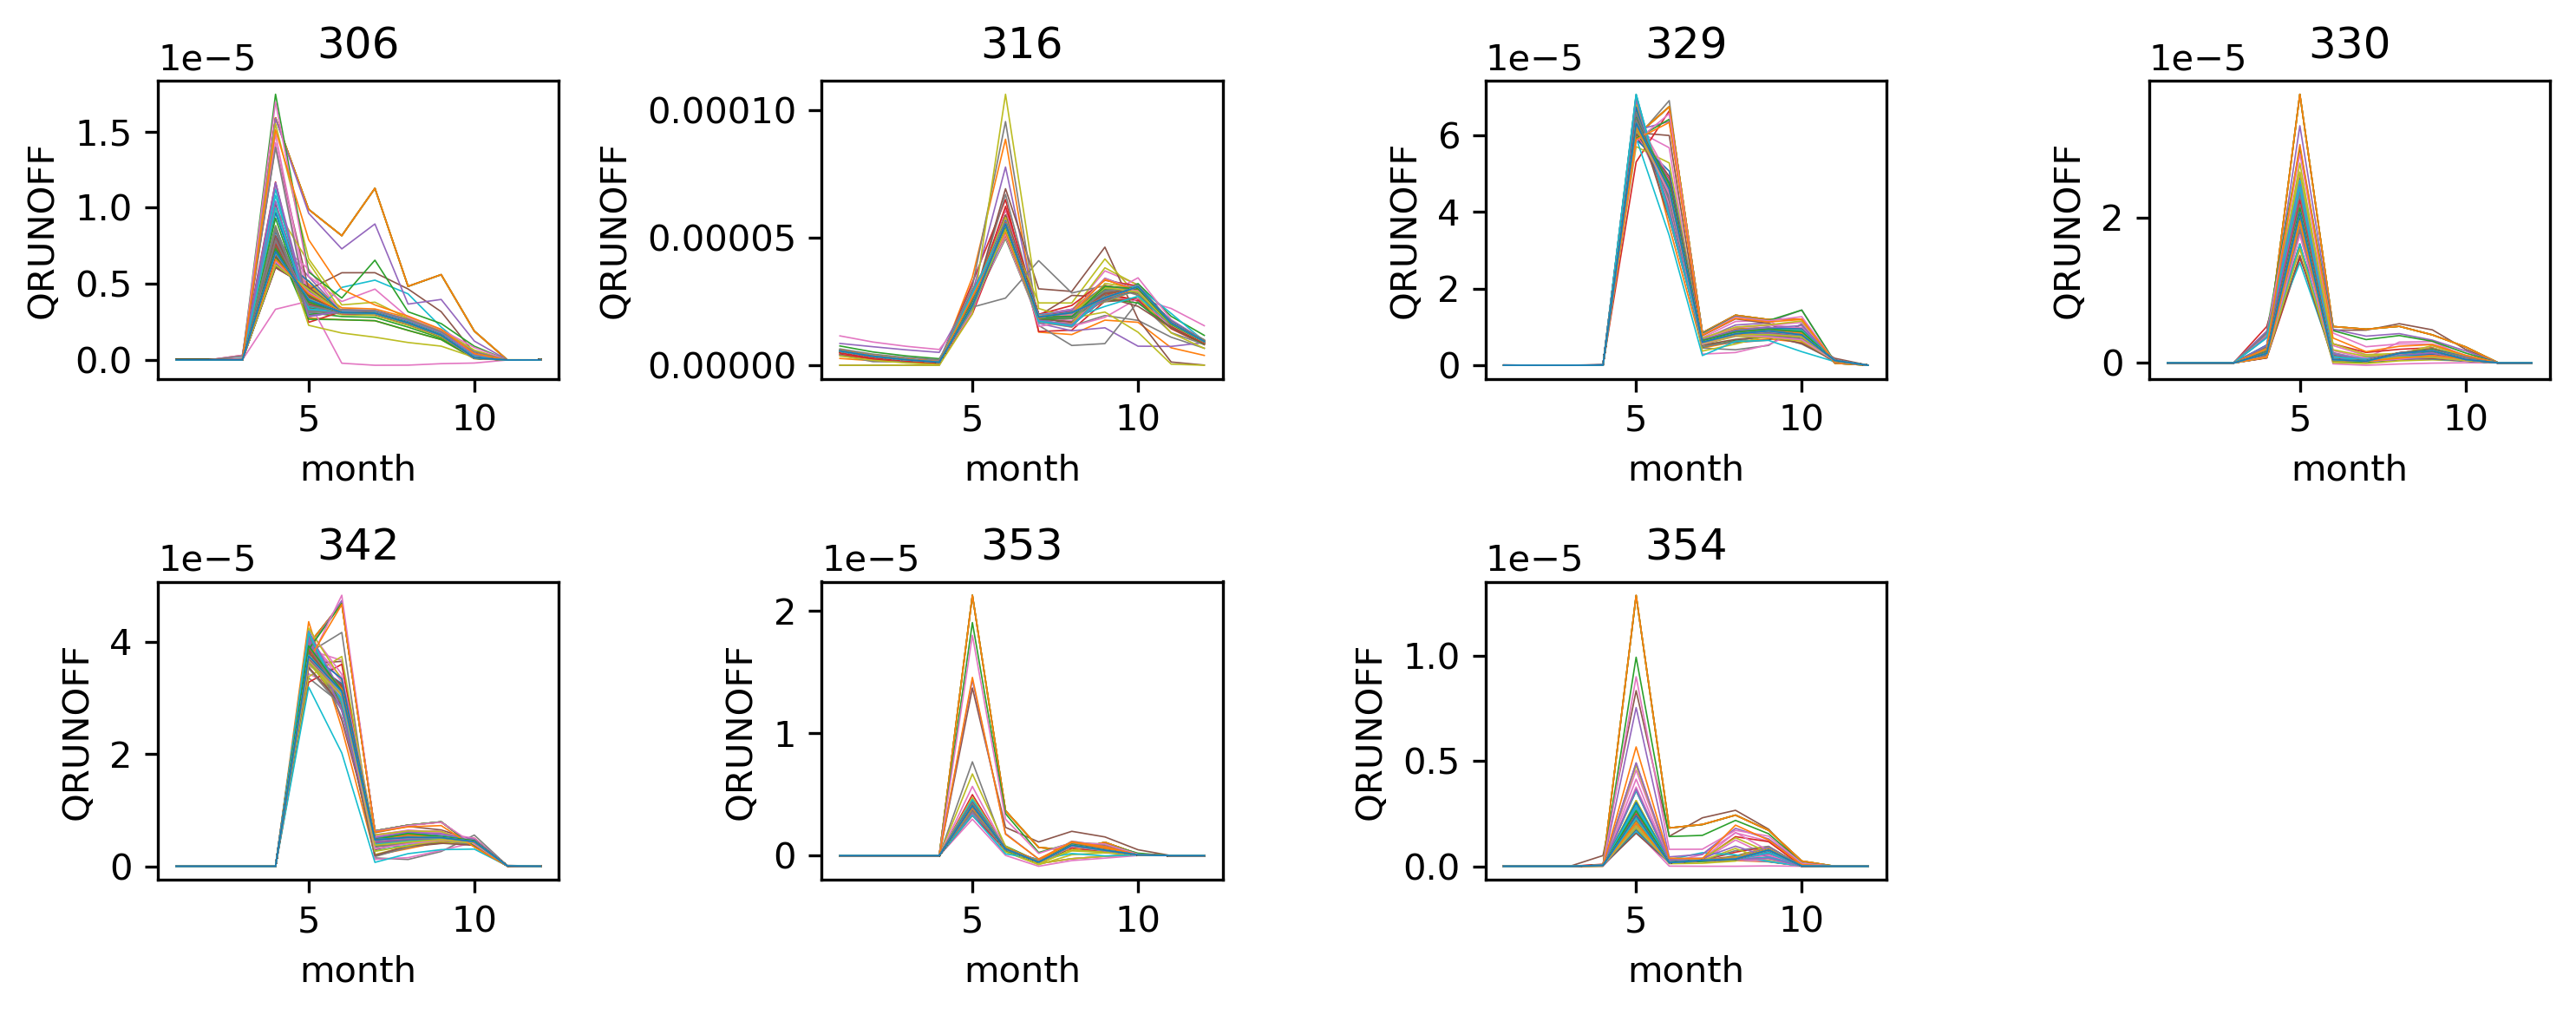

In [141]:
plt.figure(figsize=[10,4],dpi=100)
for grid in hydro_mean_seasonality.gridcell.values:
    plt.subplot(2,4,grid+1)
    for i in range(371):
        hydro_mean_seasonality.QRUNOFF.sel(gridcell=grid, ens=i).plot(lw=0.4)
    print('done with grid %s'%(grid_within_domain[grid]))
    plt.title(grid_within_domain[grid])
plt.tight_layout()

done with grid 0
done with grid 1
done with grid 2
done with grid 3
done with grid 4
done with grid 5
done with grid 6


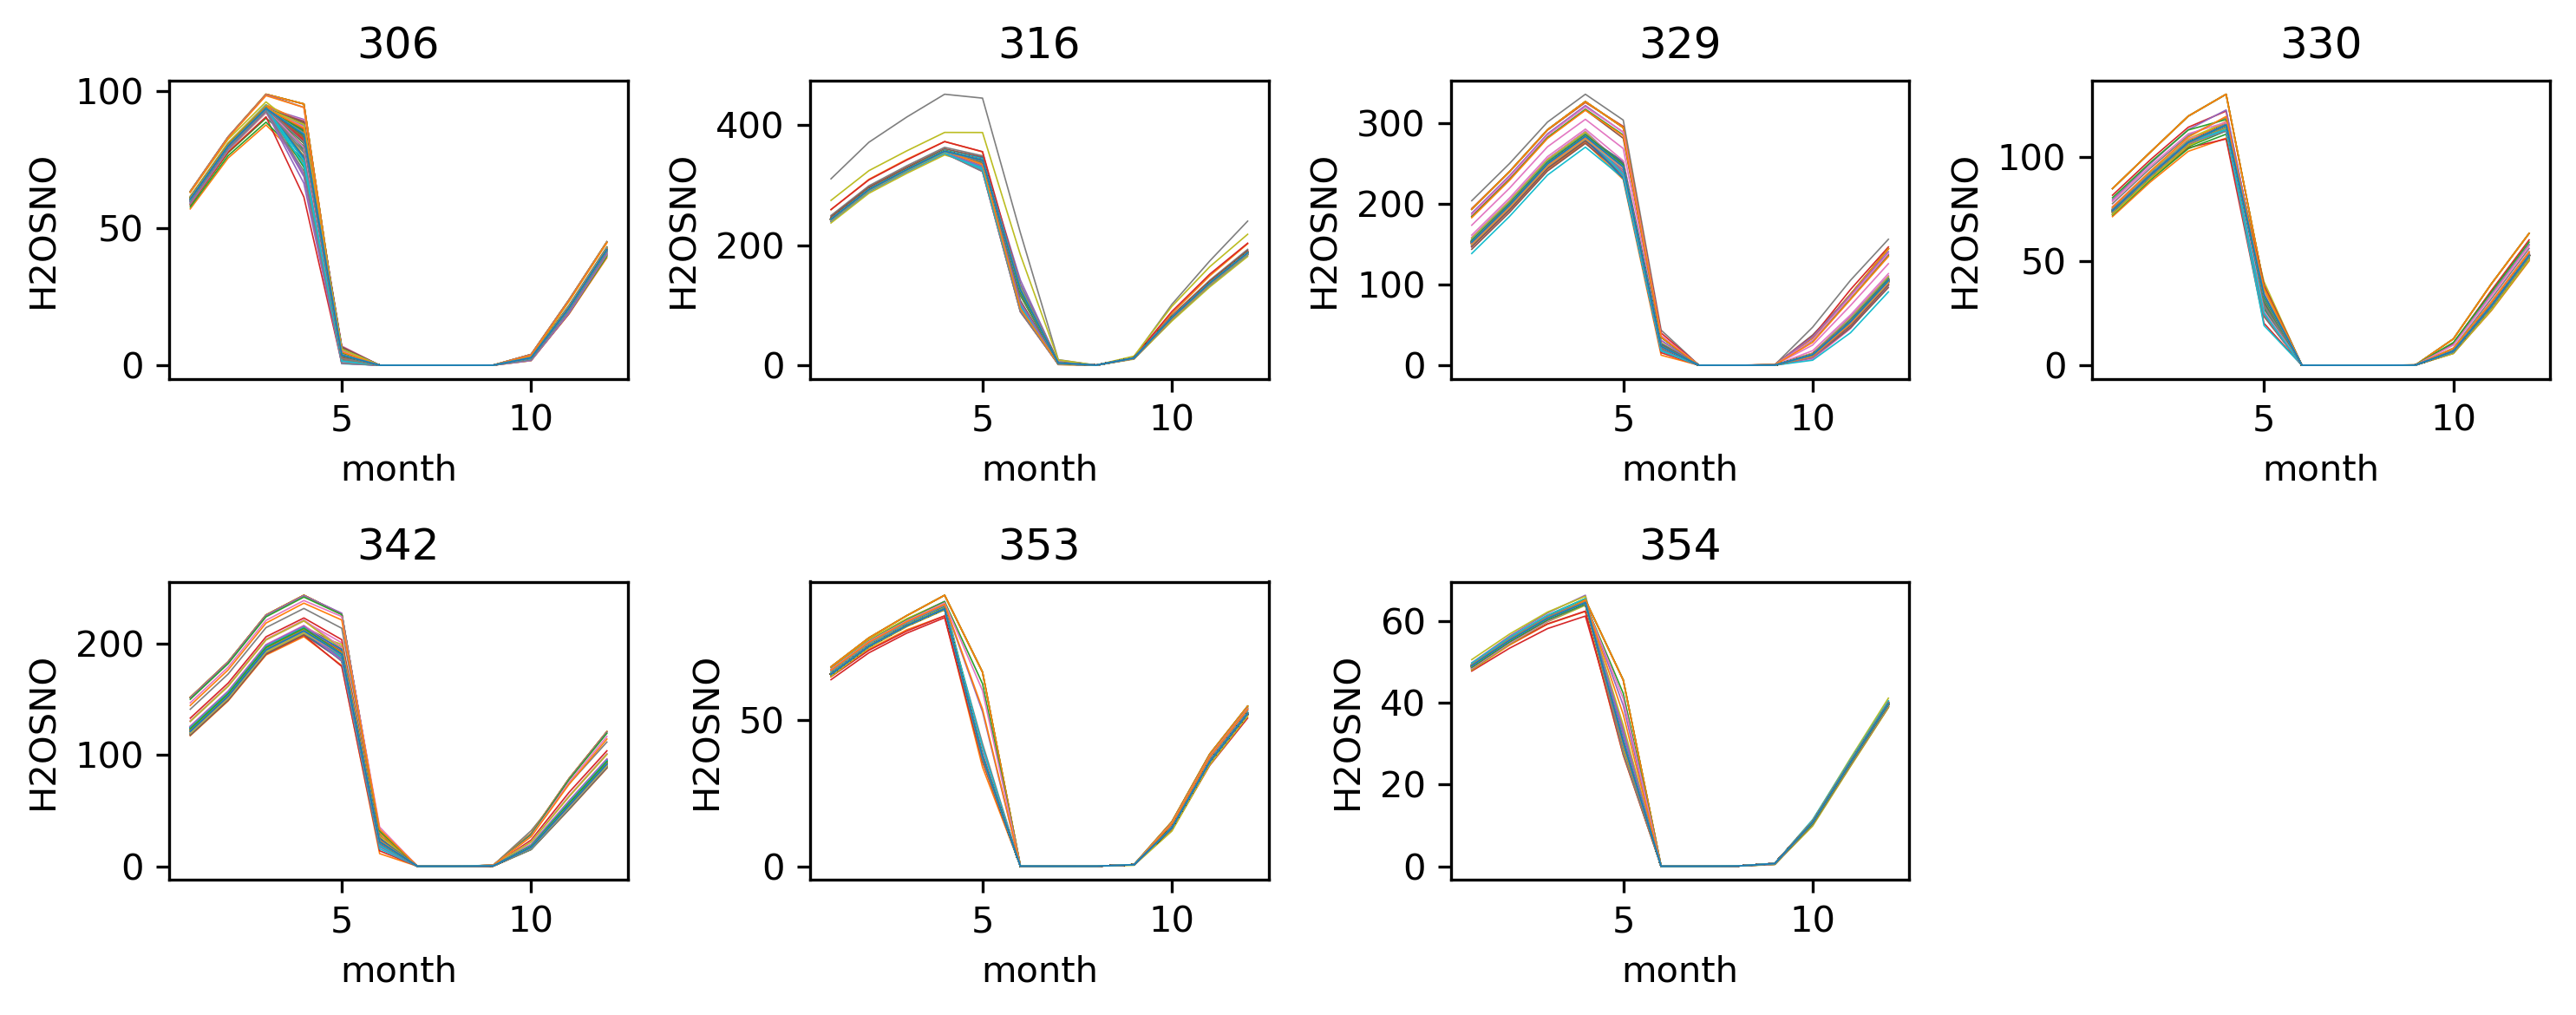

In [36]:
plt.figure(figsize=[10,4],dpi=100)
for grid in hydro_mean_seasonality.gridcell.values:
    plt.subplot(2,4,grid+1)
    for i in range(371):
        hydro_mean_seasonality.H2OSNO.sel(gridcell=grid, ens=i).plot(lw=0.4)
    print('done with grid %s'%(grid))
    plt.title(grid_within_domain[grid])
plt.tight_layout()

In [32]:
%%time
nyrs=10
hydro_mean = ds_ens.sel(gridcell=grid_within_domain).mean(dim='time')
hydro_mean_arctic = hydro_mean.mean(dim='gridcell').load()

CPU times: user 5.22 s, sys: 126 ms, total: 5.34 s
Wall time: 12.4 s


Text(0, 0.5, 'QRUNOFF(mm/s)')

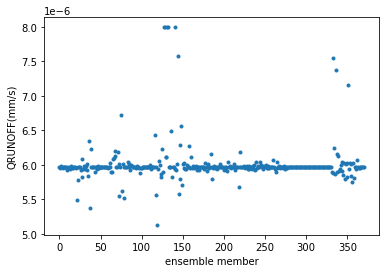

In [41]:
plt.plot(hydro_mean_arctic.QRUNOFF,'.')
plt.xlabel('ensemble member')
plt.ylabel('QRUNOFF(mm/s)')

Text(0, 0.5, 'QRUNOFF(mm/s)')

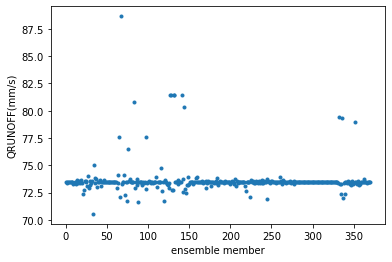

In [42]:
plt.plot(hydro_mean_arctic.H2OSNO,'.')
plt.xlabel('ensemble member')
plt.ylabel('QRUNOFF(mm/s)')

In [33]:
df_param = pd.DataFrame(np.transpose([ds_ens.param, ds_ens.minmax]), columns=['param','minmax'])

In [39]:
df_param

,param,minmax
0,default,default
1,taulnir,min
2,taulnir,max
3,taulvis,min
4,taulvis,max
...,...,...
366,FR,max
367,Q10,min
368,Q10,max
369,CWD,min


In [48]:
param_list_maxmin = []
mean_corr_coef_list = []
mean_relative_diff_list = []
mean_amplitude_list = []

for p_s in np.unique(df_param['param'].values):
    df_sel = df_param[df_param['param']==p_s]
    if len(df_sel) != 2:
        print(df_sel.values)
    else:
        param_list_maxmin.append(p_s)
        id_ = df_sel.index.values
        corr_coeff_list = []
        relative_diff_list = []
        amplitude_list = []
        for i_grid,grid in enumerate(grid_within_domain):
            q_da_1 = ds_ens_w_domain.QRUNOFF.sel(ens=id_[0],gridcell=i_grid)
            q_da_2 = ds_ens_w_domain.QRUNOFF.sel(ens=id_[1],gridcell=i_grid)
            q_da_default = ds_ens_w_domain.QRUNOFF.sel(ens=0,gridcell=i_grid)

            mean_q_1 = ds_ens_mean.QRUNOFF.sel(ens=id_[0],gridcell=grid)
            mean_q_2 = ds_ens_mean.QRUNOFF.sel(ens=id_[1],gridcell=grid)
            mean_q_default = ds_ens_mean.QRUNOFF.sel(ens=0,gridcell=grid)

            # calculate correlation coefficient
            corr_coeff = (abs((1-np.corrcoef(q_da_1,q_da_default)[0][1])) + \
                          abs((1-np.corrcoef(q_da_2,q_da_default)[0][1])))/2

            # calculate relative difference
            relative_diff = (abs((mean_q_1-mean_q_default)/mean_q_default)+ \
                             abs((mean_q_2-mean_q_default)/mean_q_default))/2

            # amplitude
            ap_1 = np.mean(q_da_1.groupby('time.year').max() - q_da_1.groupby('time.year').min())
            ap_2 = np.mean(q_da_2.groupby('time.year').max() - q_da_2.groupby('time.year').min())
            ap_default = np.mean(q_da_default.groupby('time.year').max() - q_da_default.groupby('time.year').min())
            amplitude = (abs((ap_1-ap_default)/ap_default) + \
                         abs((ap_2-ap_default)/ap_default))/2

            corr_coeff_list.append(corr_coeff)
            relative_diff_list.append(relative_diff)
            amplitude_list.append(amplitude)
        mean_corr_coef = np.mean(corr_coeff_list)
        mean_corr_coef_list.append(mean_corr_coef)
        mean_relative_diff = np.mean(relative_diff_list)
        mean_relative_diff_list.append(mean_relative_diff)
        mean_amplitude = np.mean(amplitude_list)
        mean_amplitude_list.append(mean_amplitude)


[['a_coef' 'min']]
[['a_exp' 'max']]
[['accum_factor' 'max']]
[['aq_sp_yield_min' 'min']]
[['cryoturb_diffusion_k' 'max']]
[['default' 'default']]
[['fnr' 'min']]
[['interception_fraction' 'min']]
[['lai_dl' 'max']]
[['maxpsi_hr' 'min']]
[['n_baseflow' 'max']]
[['rf_s2s1_bgc' 'max']]
[['theta_ip' 'max']]
[['watsat_sf' 'min']]
[['wind_snowcompact_fact' 'max']]


In [219]:
# mean_relative_diff_list

In [220]:
# mean_corr_coef_list

In [49]:
df_runoff_metric = pd.DataFrame(np.transpose([mean_corr_coef_list,mean_relative_diff_list,mean_amplitude_list]),
                                index=param_list_maxmin, columns=['corr_coef','relative_diff','amplitude'])

In [52]:
df_corr_coef_sort = df_runoff_metric.sort_values('corr_coef',ascending=False)
df_relative_diff_sort = df_runoff_metric.sort_values('relative_diff',ascending=False)
df_amplitude_sort = df_runoff_metric.sort_values('amplitude',ascending=False)

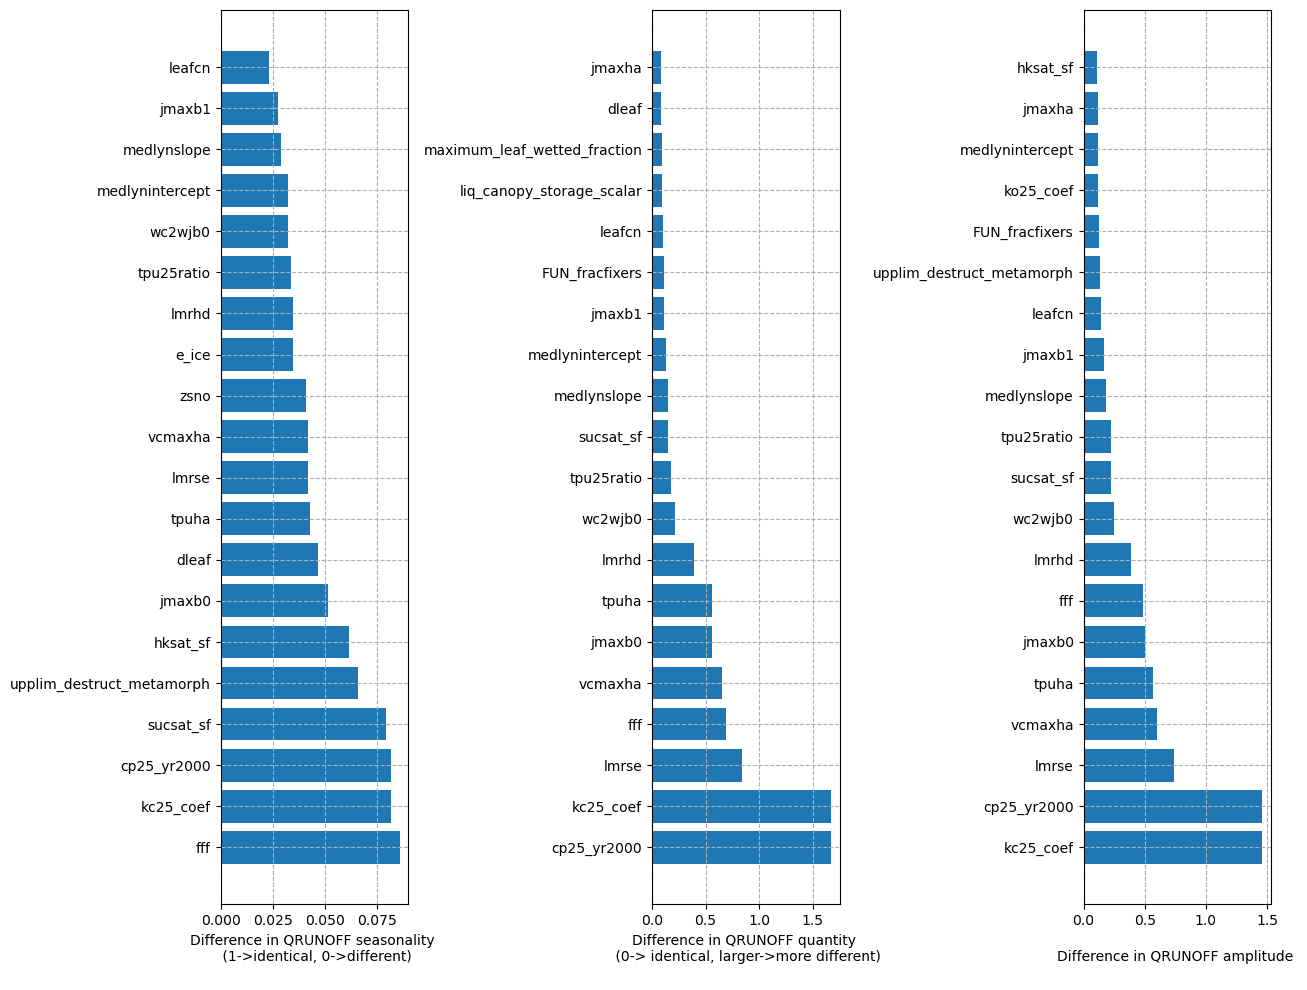

In [74]:
df_corr_coef_sel = df_corr_coef_sort[['corr_coef']].iloc[0:20]
df_relative_diff_sel = df_relative_diff_sort[['relative_diff']].iloc[0:20]
df_amplitude_sel = df_amplitude_sort[['amplitude']].iloc[0:20]

plt.figure(figsize=[13,10],dpi=100)
plt.subplot(1,3,1)
plt.barh(df_corr_coef_sel.index.values,df_corr_coef_sel['corr_coef'])
plt.xlabel('Difference in QRUNOFF seasonality \n (1->identical, 0->different)')
# plt.xlim([0,1])
plt.grid(ls='--')

plt.subplot(1,3,2)
plt.barh(df_relative_diff_sel.index.values,df_relative_diff_sel['relative_diff'])
plt.xlabel('Difference in QRUNOFF quantity \n (0-> identical, larger->more different)')
plt.grid(ls='--')

plt.subplot(1,3,3)
plt.barh(df_amplitude_sel.index.values,df_amplitude_sel['amplitude'])
plt.xlabel('\nDifference in QRUNOFF amplitude \n ')
plt.grid(ls='--')


plt.tight_layout()

# swe parameters

In [57]:
def cal_snow_rate(swe_da,year_start, year_end, thres):
    '''
    this is only for calcluate snow melt rate at monthly timestep
    '''
    snow_melt_rate_list = []
    for year in range(year_start,year_end+1):
        yr = "%04i"%(year)
        month_w_max_snow = int(swe_da.sel(time=slice("%s-01"%(yr),"%s-08"%(yr))).argmax()) + 1
        month_w_no_snow = np.where(swe_da.sel(time=slice("%s-01"%(yr),"%s-08"%(yr)))<thres)[0] +1
        if len(month_w_no_snow) == 0:
            month_w_no_snow = [7] # august
        duration_melt = month_w_no_snow[0] - month_w_max_snow
        
        snow_melt_rate =(float(swe_da.sel(time=slice("%s-%s"%(yr,"%02i"%month_w_max_snow),
                                               "%s-%s"%(yr,"%02i"%month_w_max_snow)))) - 
                         float(swe_da.sel(time=slice("%s-%s"%(yr,"%02i"%month_w_no_snow[0]),
                                               "%s-%s"%(yr,"%02i"%month_w_no_snow[0])))))/ \
                         duration_melt
        snow_melt_rate_list.append(snow_melt_rate)
#         print(month_w_max_snow,month_w_no_snow[0], snow_melt_rate, duration_melt,
#               float(swe_da.sel(time=slice("%s-%s"%(yr,"%02i"%month_w_max_snow),"%s-%s"%(yr,"%02i"%month_w_max_snow)))),
#               float(swe_da.sel(time=slice("%s-%s"%(yr,"%02i"%month_w_no_snow[0]),"%s-%s"%(yr,"%02i"%month_w_no_snow[0])))))
    return np.mean(snow_melt_rate_list)

In [58]:
thres = 0.1 # unit mm
num_month = len(ds_ens_w_domain.time)

# generate empty list
param_list_maxmin = []
mean_pct_time_w_snow_list = []
mean_relative_max_swe_list = []
mean_swe_melt_rate_list = []

for p_s in np.unique(df_param['param'].values):
    df_sel = df_param[df_param['param']==p_s]
    if len(df_sel) != 2:
        print(df_sel.values)
    else:
        param_list_maxmin.append(p_s)
        id_ = df_sel.index.values
        pct_time_w_snow_list = []
        relative_max_swe_list = []
        swe_melt_rate_list =[]
        for i_grid,grid in enumerate(grid_within_domain):
            swe_da_1 = ds_ens_w_domain.H2OSNO.sel(ens=id_[0],gridcell=i_grid)
            swe_da_2 = ds_ens_w_domain.H2OSNO.sel(ens=id_[1],gridcell=i_grid)
            swe_da_default = ds_ens_w_domain.H2OSNO.sel(ens=0,gridcell=i_grid) #.groupby('time.month').max().values.mean()
            swe_pt_default = np.sum(swe_da_default.values>thres)

            # snow persistence duration
            pct_time_w_snow = (abs((np.sum(swe_da_1.values>thres)-swe_pt_default)/swe_pt_default)+
                               abs((np.sum(swe_da_2.values>thres)-swe_pt_default)/swe_pt_default))/2

            # relative maximum swe
            max_swe_1 = swe_da_1.groupby('time.month').max().values.mean()
            max_swe_2 = swe_da_2.groupby('time.month').max().values.mean()
            max_swe_default = swe_da_default.groupby('time.month').max().values.mean()
            relative_max_swe = (abs((max_swe_1 - max_swe_default)/max_swe_default) + \
                                abs((max_swe_2 - max_swe_default)/max_swe_default))/2

            # snow melt rate
            melt_rate_1 = cal_snow_rate(swe_da_1,2005,2014, thres)
            melt_rate_2 = cal_snow_rate(swe_da_2,2005,2014, thres)
            melt_rate_default = cal_snow_rate(swe_da_default,2005,2014, thres)

            swe_melt_rate = (abs((melt_rate_1- melt_rate_default)/melt_rate_default) + \
                             abs((melt_rate_2- melt_rate_default)/melt_rate_default))/2

            pct_time_w_snow_list.append(pct_time_w_snow)
            relative_max_swe_list.append(relative_max_swe)
            swe_melt_rate_list.append(swe_melt_rate)
        mean_pct_time_w_snow = np.mean(pct_time_w_snow_list)
        mean_pct_time_w_snow_list.append(mean_pct_time_w_snow)
        mean_relative_max_swe = np.mean(relative_max_swe_list)
        mean_relative_max_swe_list.append(mean_relative_max_swe)
        mean_swe_melt_rate = np.mean(swe_melt_rate_list)
        mean_swe_melt_rate_list.append(mean_swe_melt_rate)

[['a_coef' 'min']]
[['a_exp' 'max']]
[['accum_factor' 'max']]
[['aq_sp_yield_min' 'min']]
[['cryoturb_diffusion_k' 'max']]
[['default' 'default']]
[['fnr' 'min']]
[['interception_fraction' 'min']]
[['lai_dl' 'max']]
[['maxpsi_hr' 'min']]
[['n_baseflow' 'max']]
[['rf_s2s1_bgc' 'max']]
[['theta_ip' 'max']]
[['watsat_sf' 'min']]
[['wind_snowcompact_fact' 'max']]


In [59]:
df_swe_metric = pd.DataFrame(np.transpose([mean_pct_time_w_snow_list, mean_relative_max_swe_list,mean_swe_melt_rate_list]),
                                index=param_list_maxmin, columns=['pct_time_w_snow','relative_max_swe','swe_melt_rate'])

In [60]:
df_pct_time_w_snow_sort = df_swe_metric.sort_values('pct_time_w_snow',ascending=False)
df_relative_max_swe_sort = df_swe_metric.sort_values('relative_max_swe',ascending=False)
df_swe_melt_rate_sort = df_swe_metric.sort_values('swe_melt_rate',ascending=False)


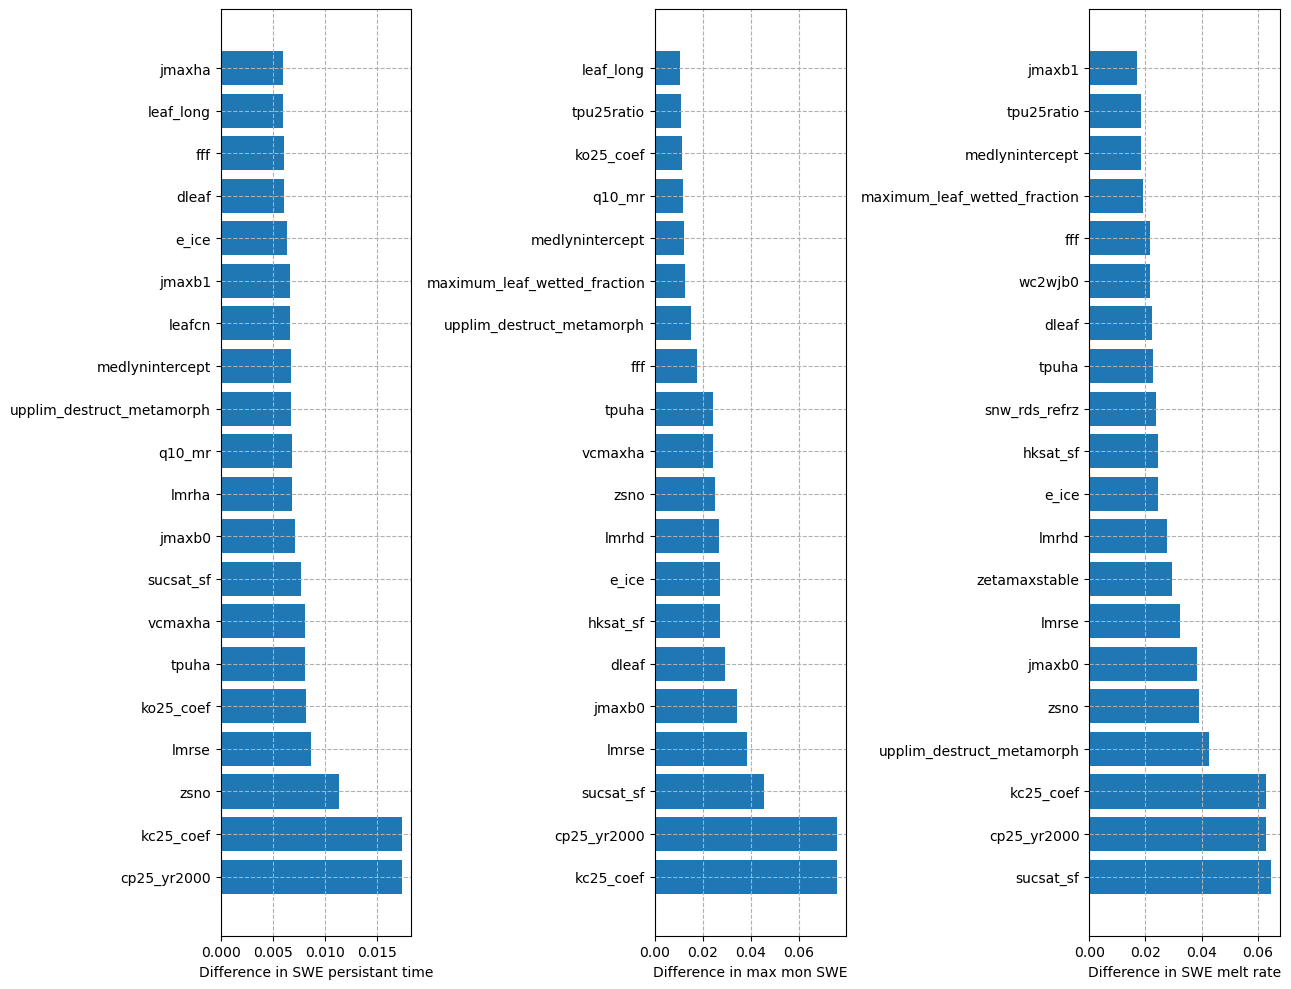

In [75]:
df_pct_time_w_snow_sel = df_pct_time_w_snow_sort[['pct_time_w_snow']].iloc[0:20]
df_relative_max_swe_sel = df_relative_max_swe_sort[['relative_max_swe']].iloc[0:20]
df_swe_melt_rate_sel = df_swe_melt_rate_sort[['swe_melt_rate']].iloc[0:20]

plt.figure(figsize=[13,10],dpi=100)
plt.subplot(1,3,1)
plt.barh(df_pct_time_w_snow_sel.index.values,df_pct_time_w_snow_sel['pct_time_w_snow'])
plt.xlabel('Difference in SWE persistant time')
plt.grid(ls='--')

plt.subplot(1,3,2)
plt.barh(df_relative_max_swe_sel.index.values,df_relative_max_swe_sel['relative_max_swe'])
plt.xlabel('Difference in max mon SWE')
plt.grid(ls='--')

plt.subplot(1,3,3)
plt.barh(df_swe_melt_rate_sel.index.values,df_swe_melt_rate_sel['swe_melt_rate'])
plt.xlabel('Difference in SWE melt rate')
plt.grid(ls='--')

plt.tight_layout()

In [66]:
df_corr_coef_sel

,corr_coef
fff,0.085783
kc25_coef,0.081664
cp25_yr2000,0.081664
sucsat_sf,0.079167
upplim_destruct_metamorph,0.065636
hksat_sf,0.061454
jmaxb0,0.051491
dleaf,0.046699
tpuha,0.043060
lmrse,0.041828


In [76]:
num_top_param = 20
df_corr_coef_sel['score'] = np.arange(num_top_param,0,-1)
df_relative_diff_sel['score'] = np.arange(num_top_param,0,-1)
df_amplitude_sel['score'] = np.arange(num_top_param,0,-1)
df_pct_time_w_snow_sel['score'] = np.arange(num_top_param,0,-1)
df_relative_max_swe_sel['score'] = np.arange(num_top_param,0,-1)
df_swe_melt_rate_sel['score'] = np.arange(num_top_param,0,-1)

df_corr_coef_sel['count'] = 1
df_relative_diff_sel['count'] = 1
df_amplitude_sel['count'] = 1
df_pct_time_w_snow_sel['count'] = 1
df_relative_max_swe_sel['count'] = 1
df_swe_melt_rate_sel['count'] = 1


In [77]:
df_param_sel = pd.concat([df_corr_coef_sel,df_relative_diff_sel,df_amplitude_sel,df_pct_time_w_snow_sel,df_relative_max_swe_sel,df_swe_melt_rate_sel]).dropna(axis=1)
df_param_sel = df_param_sel.groupby(df_param_sel.index).sum()

In [78]:
df_param_sel_sort = df_param_sel.sort_values(['score','count'],ascending=False)

In [81]:
df_param_sel_sort.to_csv('ppe/param_selection/params_selected_not_normalized.csv')

In [80]:
len(df_param_sel_sort)

30